## Intro

Being a job search engine, it’s helpful if we can suggest an approximate salary to job seekers
for a given job post. Unfortunately, not all job postings designate the salary. This is where you
come in: Your first task as an Indeed Data Scientist is to develop a salary prediction system.
The goal: provide estimated salaries for a new job posting.

#### Data supplied:
You are given three CSV (comma--separated) data files:
- train_features_DATE.csv: Each row represents metadata for an individual job posting. The
“jobId” column represents a unique identifier for the job posting. The remaining columns
describe features of the job posting.
- train_salaries_DATE.csv: Each row associates a “jobId” with a “salary”.
- test_features_DATE.csv: Similar to train_features_DATE.csv, each row represents metadata
for an individual job posting.

The first row of each file contains headers for the columns. Keep in mind that the metadata and
salary data has been extracted by our aggregation and parsing systems. As such, it’s possible
that the data is dirty (may contain errors).


#### The task

You must build a model to predict the salaries for the job postings contained in
test_features_DATE.csv. The output of your system should be a CSV file entitled
test_salaries.csv where each row has the following format: jobId, salary
As a reference, your output should mirror the format of train_salaries_DATE.csv.

In [1]:
# Import libraries for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

# Pretty display for notebooks
%matplotlib inline

%load_ext autoreload
%autoreload 1

C:\Users\Karthik\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load the dataset

In [116]:
%time
# Load the Boston housing dataset
train_features = pd.read_csv('data/train_features_2013-03-07.csv')
train_salaries = pd.read_csv('data/train_salaries_2013-03-07.csv')
  
# Success
#print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Wall time: 0 ns


### Inspect and clean the data

In [117]:
train_features.head(5)
train_features.shape
train_salaries.head(5)
train_salaries.shape

jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  
0   HEALTH               10                   83  
1      WEB                3                   73  
2   HEALTH               10                   38  
3     AUTO                8                   17  
4  FINANCE                8                   16

(1000000, 8)

jobId  salary
0  JOB1362684407687     130
1  JOB1362684407688     101
2  JOB1362684407689     137
3  JOB1362684407690     142
4  JOB1362684407691     163

(1000000, 2)

In [118]:
# Quick check to see if there are any dupes in the key column

train_salaries['jobId'].is_unique
train_features['jobId'].is_unique

True

True

In [119]:
# Merge dataframes to be sure that we are matching correct x,y rows

train_data = train_features.merge(train_salaries, on=['jobId'], how='inner')
train_data.shape

(1000000, 9)

In [120]:
#Extract numeric job ID and set it as index.
train_data['jobId'] = train_data['jobId'].str.extract(r'^JOB(\d+)', expand=False)
train_data['jobId'] = pd.to_numeric(train_data['jobId'])
train_data.set_index('jobId', inplace=True)

In [121]:
train_data.head(5)
#(sys.getsizeof(train_data)/1024)/1024
#train_data.dtypes

companyId         jobType       degree      major industry  \
jobId                                                                      
1362684407687    COMP37             CFO      MASTERS       MATH   HEALTH   
1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE      WEB   
1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   HEALTH   
1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY     AUTO   
1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS  FINANCE   

               yearsExperience  milesFromMetropolis  salary  
jobId                                                        
1362684407687               10                   83     130  
1362684407688                3                   73     101  
1362684407689               10                   38     137  
1362684407690                8                   17     142  
1362684407691                8                   16     163

In [122]:
#Inspect if the data has any NaN values
train_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)
train_data.isnull().sum()

companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [123]:
# Few more checks
train_data[train_data.yearsExperience < 0].shape
train_data[train_data.milesFromMetropolis < 0].shape
train_data[train_data.salary <= 0].shape

(0, 8)

(0, 8)

(5, 8)

In [124]:
#Drop the rows where salary == 0. It is possible to fill them with the mean/median, 
# but doesn't seem worth it given the size of our data
train_data[train_data.salary == 0]

companyId         jobType       degree        major industry  \
jobId                                                                        
1362684438246    COMP44          JUNIOR     DOCTORAL         MATH     AUTO   
1362684903671    COMP34          JUNIOR         NONE         NONE      OIL   
1362685059763    COMP25             CTO  HIGH_SCHOOL         NONE     AUTO   
1362685223816    COMP42         MANAGER     DOCTORAL  ENGINEERING  FINANCE   
1362685235843    COMP40  VICE_PRESIDENT      MASTERS  ENGINEERING      WEB   

               yearsExperience  milesFromMetropolis  salary  
jobId                                                        
1362684438246               11                    7       0  
1362684903671                1                   25       0  
1362685059763                6                   60       0  
1362685223816               18                    6       0  
1362685235843                3                   29       0

In [125]:
train_data = train_data.query('salary != 0')
train_data.dropna(inplace=True)
train_data.shape

(999995, 8)

#### Visualize the data distribution

In [126]:
train_data['major'].value_counts()
train_data[train_data.major == 'NONE']['industry'].value_counts()

NONE           532353
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58594
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57800
Name: major, dtype: int64

WEB          76267
EDUCATION    76231
SERVICE      76140
OIL          76130
FINANCE      75934
HEALTH       75835
AUTO         75816
Name: industry, dtype: int64

In [226]:
train_data[train_data.major == 'NONE']['degree'].value_counts()

HIGH_SCHOOL    236851
NONE           236776
DOCTORAL        19641
BACHELORS       19471
MASTERS         19261
Name: degree, dtype: int64

In [227]:
train_data[train_data.major == 'NONE']['jobType'].value_counts()

JANITOR           124971
VICE_PRESIDENT     58454
SENIOR             58377
MANAGER            58287
JUNIOR             58127
CTO                58111
CFO                57871
CEO                57802
Name: jobType, dtype: int64

C:\Users\Karthik\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  from ipykernel import kernelapp as app


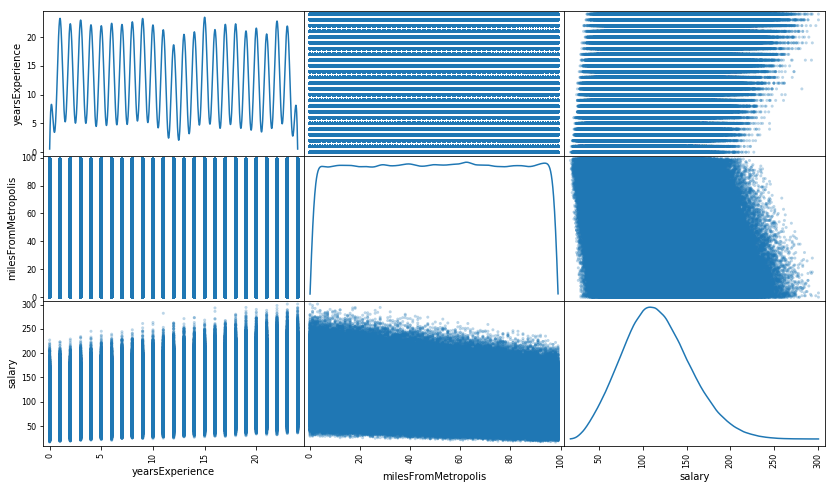

In [114]:
%time
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(train_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

- There is a predictable linear relationship between 
    -- milesFromMetropolis and salary. 
    -- yearsExperience and salary
- 'milesFromMetropolis' has an uniform distrubution
- 'salary' has a normal distribution. It may be prudent to remove some outliers from this columns

#### Detect and handle outliers (Tukey's method)

In [127]:
feature = 'salary'
# Calculate Q1 (25th percentile of the data) for the given feature
Q1 = np.percentile(train_data[feature], 25)

# Calculate Q3 (75th percentile of the data) for the given feature
Q3 = np.percentile(train_data[feature], 75)

# Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
step = 1.5 * (Q3-Q1)

feature_outliers = train_data[~((train_data[feature] >= Q1 - step) & (train_data[feature] <= Q3 + step))]
#counter.update(feature_outliers.index.values)

In [128]:
print("Higher salary cutoff = {}".format(Q3 + step))

Higher salary cutoff = 220.5


In [129]:
unlikely = feature_outliers[feature_outliers.jobType.isin(['JUNIOR', 'SENIOR', 'JANITOR'])]
unlikely['jobType'].value_counts()

SENIOR    66
JUNIOR    20
Name: jobType, dtype: int64

In [130]:
unlikely.sort_values(by='salary').head(5)

companyId jobType     degree        major industry  \
jobId                                                              
1362685084129    COMP32  SENIOR   DOCTORAL     BUSINESS  FINANCE   
1362684879344    COMP37  SENIOR   DOCTORAL         MATH  FINANCE   
1362684642688    COMP21  SENIOR  BACHELORS      COMPSCI  FINANCE   
1362684985181     COMP6  SENIOR   DOCTORAL  ENGINEERING     AUTO   
1362684835280    COMP54  JUNIOR   DOCTORAL  ENGINEERING  FINANCE   

               yearsExperience  milesFromMetropolis  salary  
jobId                                                        
1362685084129               21                   28     221  
1362684879344               24                   39     221  
1362684642688               23                    1     221  
1362684985181               24                    0     221  
1362684835280               23                    3     221

In [131]:
train_data['degree'].value_counts()

HIGH_SCHOOL    236975
NONE           236853
BACHELORS      175495
DOCTORAL       175362
MASTERS        175310
Name: degree, dtype: int64

In [181]:
# Quick plot to check company vs salary. 
#company_id = train_data['companyId'].str.extract(r'^COMP(\d+)', expand=False)
#iplot([{"x": company_id, "y": train_data['salary']}])
#iplot([{"x": train_data['jobType'], "y": train_data['yearsExperience']}])

#### Some observations 
 * We see that the salary outliers  are not company specific.
 * Also, that jobType has a uniform distribution in yearsExperience
 * While unlikey, Seniors and Juniors can have high salaries. Need not be directly related to years of experience either. 
 * Since these are a small fraction of the data, we'll do the following pruning.
 
 Option 1: Remove all outliers
 
 Option 2: Remove all Juniors and Seniors with salaries beyond the higher salary cutoff (i.e 220+). Then remove all outliers beyond an arbitrary salary cutoff of 230

In [132]:
managers_230 = feature_outliers[~feature_outliers.jobType.isin(['JUNIOR', 'SENIOR', 'JANITOR']) & (feature_outliers.salary > 230)]
managers_230.shape
unlikely.shape

(3653, 8)

(86, 8)

In [133]:
# Remove the outliers, if any were specified
train_data.drop(managers_230.index, inplace=True)
train_data.drop(unlikely.index, inplace=True)
train_data.shape

(996256, 8)

#### Let's see how the salary varies with the categorical fields

In [134]:
from plotly import tools
import plotly.graph_objs as go


jobType_avg = train_data.groupby(by='jobType').mean().sort_values('salary')
trace1 = go.Scatter(x=jobType_avg.index, y=jobType_avg['salary'], name='jobType')

degree_avg = train_data.groupby(by='degree').mean().sort_values('salary')
trace2 = go.Scatter(x=degree_avg.index, y=degree_avg['salary'], name='degree')

major_avg = train_data.groupby(by='major').mean().sort_values('salary')
trace3 = go.Scatter(x=major_avg.index, y=major_avg['salary'], name='major')

industry_avg = train_data.groupby(by='industry').mean().sort_values('salary')
trace4 = go.Scatter(x=industry_avg.index, y=industry_avg['salary'], name='industry')

fig = tools.make_subplots(rows=2, cols=2, shared_yaxes=True)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)

fig['layout'].update(height=600, width=600,
                     title='Variation of salary with categorical fields')
iplot(fig, filename='Variation of salary with categorical fields')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]
[ (2,1) x3,y2 ]  [ (2,2) x4,y2 ]



### Prepare the data for training

In [348]:
#Make a copy of the train_data
train_data_raw = train_data.copy(deep=True)

In [349]:
# Import sklearn.preprocessing.RobustScaler
from sklearn.preprocessing import RobustScaler, StandardScaler

# Initialize a scaler, then apply it to the features
x_scaler = StandardScaler()
numerical = ['yearsExperience', 'milesFromMetropolis']
train_data_raw[numerical] = x_scaler.fit_transform(train_data_raw[numerical])

y_scaler = StandardScaler()
train_data_raw[['salary']] = y_scaler.fit_transform(train_data_raw[['salary']])

# Show an example of a record with scaling applied
display(train_data_raw.head(n = 1))

companyId jobType   degree major industry  yearsExperience  \
jobId                                                                      
1362684407687    COMP37     CFO  MASTERS  MATH   HEALTH        -0.272138   

               milesFromMetropolis    salary  
jobId                                         
1362684407687             1.156065  0.379404

In [350]:
#One-hot encode categorical values.
drop_cols = ['companyId']
train_data_raw.drop(columns=drop_cols, axis=1, inplace=True)
train_data_raw = pd.get_dummies(train_data_raw)
train_data_raw.head(1)

yearsExperience  milesFromMetropolis    salary  jobType_CEO  \
jobId                                                                        
1362684407687        -0.272138             1.156065  0.379404            0   

               jobType_CFO  jobType_CTO  jobType_JANITOR  jobType_JUNIOR  \
jobId                                                                      
1362684407687            1            0                0               0   

               jobType_MANAGER  jobType_SENIOR      ...       major_MATH  \
jobId                                               ...                    
1362684407687                0               0      ...                1   

               major_NONE  major_PHYSICS  industry_AUTO  industry_EDUCATION  \
jobId                                                                         
1362684407687           0              0              0                   0   

               industry_FINANCE  industry_HEALTH  industry_OIL  \
jobId                                                            
1362684407687                 0                1             0   

               industry_SERVICE  industry_WEB  
jobId                                          
1362684407687                 0             0  

[1 rows x 32 columns]

In [351]:
salary_raw = train_data_raw[['salary']]
train_data_raw.drop(columns=['salary'], axis=1, inplace=True)

### Shuffle and Split Data

In [352]:
#Make bins for stratified shuffle and split
y_bins = np.linspace(salary_raw.min(), salary_raw.max(), 6)
y_binned = np.digitize(salary_raw['salary'], y_bins)

In [353]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

random_state = 0

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data_raw, salary_raw, test_size = 0.2, 
                                                    random_state = random_state, stratify=y_binned)

# Show the results of the split
print("Training X shape is {}".format(X_train.shape))
print("Training y shape is {}".format(y_train.shape))

Training X shape is (797004, 31)
Training y shape is (797004, 1)


### Fit a few models

In [370]:
%aimport train

from train import train_predict, get_tuned_estimator, preprocess_features
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

est_A = SGDRegressor(n_iter=np.ceil(10**6 / len(y_train)))
est_B = LinearRegression()
est_C = GradientBoostingRegressor()

estimators = [est_A, est_B]#, est_C]

results = {}
for est in estimators:
    results[est] = train_predict(est, len(y_train), X_train, y_train.values.ravel(), X_test, y_test.values.ravel())
    

results

C:\Users\Karthik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning:

n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.



SGDRegressor trained on 797004 samples.
LinearRegression trained on 797004 samples.


{LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False): {'explained_variance_test': 0.7420245331963323,
  'explained_variance_train': 0.7568176988087343,
  'pred_time': 0.03800010681152344,
  'r2_score_test': 0.7420121567196613,
  'r2_score_train': 0.7566936182956343,
  'train_time': 0.7220053672790527},
 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
        loss='squared_loss', max_iter=None, n_iter=2.0, penalty='l2',
        power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
        warm_start=False): {'explained_variance_test': 0.7418550246434794,
  'explained_variance_train': 0.7566801572312266,
  'pred_time': 0.03900003433227539,
  'r2_score_test': 0.741711009867678,
  'r2_score_train': 0.7566721619204264,
  'train_time': 0.8700087070465088}}

In [371]:
#Quick plot to show what the model has learnt about salary gradients with features
iplot([{"x" : X_train.columns.values, "y": est_A.coef_}])

#### Pick a model and fine tune
All three models perform about the same with default settings. I'll pick the SGDRegressor and ffine tune since it is the fastest.

In [281]:
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.metrics import make_scorer

estimator = SGDRegressor(random_state=random_state)
params = {'alpha' : 10.0**-np.arange(1,7)}
scorer = make_scorer(r2_score)
best_estimator = get_tuned_estimator(X_train, y_train.values.ravel(), X_test, y_test.values.ravel(), estimator, params, scorer, random_state=random_state, n_jobs=16)

C:\Users\Karthik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



GridSearch time: 17.757003784179688
Best params: 

{'alpha': 1e-06}


In [282]:
# Make predictions using the unoptimized and model
predictions = est_A.predict(X_test)
best_predictions = best_estimator.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Score on testing data: {:.4f}".format(r2_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))

Unoptimized model
------
Score on testing data: 0.7419

Optimized Model
------
Final accuracy score on the testing data: 0.7417


### Notes and TODO's to improve

* Handle 'NONE' degree and major rows. They make up half the dataset - drop or interpolate?
* PCA after one-hot encoding and other feature engineering
* May need to switch to StandardSacaler for SGDRegressor


### Make predictions on the test set

In [319]:
# Load the test data
test_features = pd.read_csv('data/test_features_2013-03-07.csv')
test_features.head(1)

jobId companyId  jobType       degree major industry  \
0  JOB1362685407687    COMP33  MANAGER  HIGH_SCHOOL  NONE   HEALTH   

   yearsExperience  milesFromMetropolis  
0               22                   73

In [320]:
#Prepare the test data
numerical_cols = ['yearsExperience', 'milesFromMetropolis']

test_features = preprocess_features(test_features, drop_cols, numerical_cols, x_scaler)
test_features.head(1)

yearsExperience  milesFromMetropolis  jobType_CEO  jobType_CFO  \
jobId                                                                           
1362685407687         0.833333                 0.46            0            0   

               jobType_CTO  jobType_JANITOR  jobType_JUNIOR  jobType_MANAGER  \
jobId                                                                          
1362685407687            0                0               0                1   

               jobType_SENIOR  jobType_VICE_PRESIDENT      ...       \
jobId                                                      ...        
1362685407687               0                       0      ...        

               major_MATH  major_NONE  major_PHYSICS  industry_AUTO  \
jobId                                                                 
1362685407687           0           1              0              0   

               industry_EDUCATION  industry_FINANCE  industry_HEALTH  \
jobId                                                                  
1362685407687                   0                 0                1   

               industry_OIL  industry_SERVICE  industry_WEB  
jobId                                                        
1362685407687             0                 0             0  

[1 rows x 31 columns]

In [342]:
# Make predictions
test_predict = best_estimator.predict(test_features)
test_predict = pd.DataFrame(test_predict, index=test_features.index, columns=['salary'])
test_predict['salary'] = y_scaler.inverse_transform(test_predict).astype(int)


In [344]:
test_predict['jobId'] = test_predict.index.astype(str)
test_predict['jobId'] = test_predict['jobId'].apply(lambda x : 'JOB' + x)
test_predict.reset_index(drop=True, inplace=True)
test_predict = test_predict[['jobId', 'salary']]
test_predict.head(1)

jobId  salary
0  JOB1362685407687     115

In [347]:
# Save as csv
test_predict.to_csv('data/test_salaries_2013-03-07.csv', index=False)